# Data Science: Click-through rate optimization

**Notebook by Christian Contreras-Campana, PhD**

### Introduction

One of the key applications at TripleLift is a bidder designed to optimize the performance of campaigns. A big driver of this performance is the click through rate (clicks/impressions). We take a sample of company data (<a href="https://s3.amazonaws.com/ops.triplelift.net/public/code-test/data-code-test.tar.gz">data</a>) and use it to develop a model that is able to predict the click through rate.

The columns in the file are:
- **timestamp**: time of the impression
- **placement_id**: a unique identifier for a web page
- **browser_id**: unique identifier for a browser (firefox, chrome, ie10, etc)
- **os_id**: unique identifier for an os (windows, linux, osx)
- **region**: geographic region (states in the US)
- **country**: country code
- **is_adserver**: ignore this column
- **campaign**: unique identifier for a campaign (with it's own targeting parameters - for example target NY +
NJ)
- **creative_asset_id**: unique identifier for an image belonging to a campaign mouseovers: 1 if there was a mouseover
**clicks**: 1 if thee was there a click
- **max_duration**: if this was a video, how far did the viewer get video_length: if this was a video, what was the length of the video viewable: was the ad viewable

### Load Libraries

We load all the necessary python libraries that will permit us to load the data files, pre-process and clean the data, perform data validation, produce statistical summaries, conduct exploratory data analysis, as well as feature transformation, feature ranking, and feature selection. Python libraries will also be needed for model selection, evaluating overfitting, executing standard nested k-fold cross validation for hyper-parameter optimization and model evaluation. 

In [1]:
## Import common python libraries

import sys
import time
import math
import heapq
import os.path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import operator
import collections

# Import panda library
import pandas.core.common as com
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index

# Import scipy
import scipy as sp
from scipy.stats import ks_2samp

# Import itertools
import itertools
from itertools import cycle

# Import collections
from collections import defaultdict, Counter

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

# Import scikit-learn
import sklearn

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn import feature_selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve,
                             accuracy_score)

from sklearn.externals import joblib

# ---- Optimize bayesian
from bayes_opt import BayesianOptimization

# ---- Hyper-paramter tuning using HyperOpt library
from hyperopt.pyll import scope
from hyperopt import hp
from hyperopt import fmin, Trials, STATUS_OK, tpe, space_eval

# ---- Scikit-Learn Optimizer
from skopt import gp_minimize, forest_minimize
from skopt.plots import plot_convergence
from skopt.plots import plot_evaluations

# ---- Python utilities
from collections import defaultdict, Counter

# Import keras library
from keras.wrappers.scikit_learn import KerasClassifier

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import data science toolkit
from dskit import *

# Fix random seed for reproducibility
seed = 7
random.seed(a=seed)

# Specifying which nodes should be run interactively
#InteractiveShell.ast_node_interactivity = 'all'

Using TensorFlow backend.


Python version 2.7.13 (v2.7.13:a06454b1afa1, Dec 17 2016, 12:39:47) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Numpy version 1.13.3
Pandas version 0.20.1
Matplotlib version 2.1.0
Seaborn version 0.8.dev
Scipy version 0.19.1
Scikit-learn version 0.19.1
Imblance version 0.2.1


### Load Data Files

Most data files contain approximately 1M entries. There are a total of 8 files totaling 8M data entries. We list the features and response names. We store the data in a Pandas DataFrame for greater ease of data manipulation.

**Note: To reduce running time of the program comment out some of the input files**

In [2]:
%%time
## Load data files

# Feature names
features = ['timestamp', 'placement_id', 'browser_id', 'os_id',
            'region', 'country', 'is_adserver', 'campaign', 
            'creative_asset_id', 'mouseovers', 'clicks', 'max_duration',
            'video_length', 'viewable']

# Check loading data with sc.textFile
baseDir = os.path.join('data')
inputPath = os.path.join('ctr/')
filePath = os.path.join(baseDir, inputPath)

# Load dataset
csvList = []

csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0000_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0001_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0002_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0003_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0004_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0005_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0006_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0007_part_00', 
                           header = None, delimiter = '|', names = features))

df_raw_full = pd.concat(csvList)

print "Total number of events:", df_raw_full.shape[0]                 
print "Number of features:", df_raw_full.shape[1]

Total number of events: 8294824
Number of features: 14
CPU times: user 13 s, sys: 2.64 s, total: 15.7 s
Wall time: 16.7 s


In [3]:
%%time
## To decrease the running time even futher we reduce the number of rows 
## of the dataframe to 10k randomly sampled data entries

full = False 

df_raw = df_raw_full if full==True else df_raw_full.sample(n=200000, 
                                                           replace=False, 
                                                           random_state=seed, 
                                                           axis=None)

CPU times: user 1.5 s, sys: 1.31 s, total: 2.81 s
Wall time: 3.48 s


In [4]:
%%time
## Data pre-processing and cleaning (data munging)

# Drop irrelevant columns or columns with too many NaN
df_raw_selected = df_raw.drop(['is_adserver', 'max_duration', 'video_length'], 
                              axis=1, inplace=False) 

# Drop rows with at least one NaN
df_raw_selected.dropna(how='any', inplace=True)

# Convert timestamp from string to pandas timestamp
df_raw_selected['timestamp'] = df_raw_selected['timestamp'].apply(pd.Timestamp)

# Extract day of week from pandas timestamp
#df_raw_selected['day_of_week'] = \
#df_raw_selected['timestamp'].apply(lambda t: t.weekday_name)

# Extract hour from pandas timestamp
df_raw_selected['hour'] = df_raw_selected['timestamp'].apply(lambda t: t.hour)

# Remove duplicate entries from dataframe if there are any
df_raw_selected.drop_duplicates(inplace=True)

CPU times: user 1.74 s, sys: 156 ms, total: 1.9 s
Wall time: 1.94 s


In [5]:
df_raw_selected.drop(['timestamp', 'viewable', 'mouseovers'], axis=1, inplace=True)

### Feature Engineering

Since most machine learning algorithms cannot handle categorical (nominal) features directly we will perform **one-hot-encoding** and then droping them from the original dataframe to eliminate collinearity. We also create the features dataframe and response array which will later on be used for feature ranking and machine learning modeling.

In [6]:
%%time
## Create features dataframe and target array

df_X = df_raw_selected.drop('clicks', axis=1, inplace=False)
df_y = df_raw_selected['clicks']

# Split data into training and test
X_train, X_test, y_train, y_test = \
       train_test_split(df_X, df_y, test_size=0.33, random_state=seed)

CPU times: user 71.6 ms, sys: 10.6 ms, total: 82.2 ms
Wall time: 101 ms


In [7]:
%%time
## Label encoding

# features to label encode
columns = ['region', 'country']

# label encode
X_train, X_test = label_encoder(X_train, X_test, columns)

# drop origin "region" and "country" columns
X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)

CPU times: user 775 ms, sys: 35.8 ms, total: 811 ms
Wall time: 886 ms


In [8]:
%%%time
## Feature transformations of categorical (nominal) variables

# One-hot encoding
# Note: sparse=False for numpy.ndarray 
# else sparse=True for scipy.sparse.csr.csr_matrix
enc = OneHotEncoder(categorical_features='all', n_values='auto',
                    sparse=True, handle_unknown='ignore') 

# features to one-hot encode
column = ['placement_id', 'browser_id', 'os_id', 'region_le', 
          'country_le', 'campaign', 'creative_asset_id']

enc.fit(X_train[column])

X_train = enc.transform(X_train[column])
X_test = enc.transform(X_test[column])

CPU times: user 564 ms, sys: 129 ms, total: 693 ms
Wall time: 732 ms


## prepare models: create a mapping of ML classifier name to algorithm

In [9]:
# ---- Create a pipleline dicitonary of ML algorithms 
pipeline_search = collections.OrderedDict()

pipeline_search['LogisticRegression'] = make_pipeline(None,
        LogisticRegression(penalty='l2', C=1))

pipeline_search['RandomForestClassifier'] = make_pipeline(None,
        RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=10))

pipeline_search['GradientBoostingClassifier'] = make_pipeline(None,
        GradientBoostingClassifier(n_estimators=10, max_depth=4, learning_rate=0.2,
                                   min_samples_leaf=10))

pipeline_search['DecisionTreeClassifier'] = make_pipeline(None,
        DecisionTreeClassifier(min_samples_leaf=10))

pipeline_search['AdaBoostClassifier'] = make_pipeline(None,
        AdaBoostClassifier())

pipeline_search['BaggingClassifier'] = make_pipeline(None,
        BaggingClassifier(n_estimators=100))

pipeline_search['ExtraTreesClassifier'] = make_pipeline(None,
        ExtraTreesClassifier(min_samples_leaf=10))

pipeline_search['MultinomialNB'] = make_pipeline(None,
        MultinomialNB())

pipeline_search['DummyClassifier'] = make_pipeline(None,
        DummyClassifier(strategy='stratified', random_state=seed))

pipeline_search['kerasclassifier'] = make_pipeline(None,
        KerasClassifier(build_fn=create_model, batch_size=128,
                        nb_epoch=10, verbose=0))

## Model Building: Hyper-parameter Optimization and Model Evaluation

### Hyper-parameter Optimization and Model Evaluation

We employ a nested k-fold cross-validation utilizaiton a grid search for hyper-parameter optimization to avoid leaking information from the training dataset used to validate the hyper-parameters into the model evaluation which uses testing datasets.

In [10]:
## Hyper-parameter optimization and model evaluation

name = 'GradientBoostingClassifier'.lower()

param_grid = {name+'__n_estimators': [50],
              #name+'__learning_rate': [0.01, 0.1],
              #name+'__subsample': [0.1, 0.5],
              name+'__loss': ['exponential'],
              #'name+__min_samples_leaf': [0.3, 0.5],
              name+'__max_depth': [10]
             }

# Standard K-Fold cross-validation
k_fold = 3

outer_kfold_cv = KFold(n_splits=k_fold, shuffle=True, random_state=seed)
inner_kfold_cv = KFold(n_splits=k_fold-1, shuffle=True, random_state=seed)

In [11]:
# ---- Typical hyper-parameter optimization and model evaluaiton using grid search CV
grid = nested_grid_search_cv(pipeline_search['GradientBoostingClassifier'],
                             X_train, y_train,
                             outer_kfold_cv, inner_kfold_cv,
                             param_grid, scoring='roc_auc')

fold-1 model fitting ...
	Model validation score 0.713239318563
fold-2 model fitting ...
	Model validation score 0.757505400204
fold-3 model fitting ...
	Model validation score 0.723460437472
Final model evaluation (mean cross-val scores):
0.731401718746
Performing fit over entire training data



In [12]:
# ---- For training data
print "Parameters that gave the best results on the hold out data:", grid.best_params_
print "Mean cross-validated score (AUC) of the best estimator: %0.3f" % grid.best_score_
print "\nPipeline steps:\n%s" % grid.best_estimator_.steps

Parameters that gave the best results on the hold out data: {'gradientboostingclassifier__n_estimators': 50, 'gradientboostingclassifier__max_depth': 10, 'gradientboostingclassifier__loss': 'exponential'}
Mean cross-validated score (AUC) of the best estimator: 0.721

Pipeline steps:
[('nonetype', None), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='exponential', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]


In [14]:
# ---- For test data
x = X_test.todense()
y_score = grid.decision_function(x)

print "Test AUC (roc_auc_score): %0.3f" % roc_auc_score(y_test, y_score)
print "Test AUC (score): %0.3f" % grid.score(x, y_test)
print "Test AUC (best_estimator_ score): %0.2f" % grid.best_estimator_.score(x, y_test)

Test AUC (roc_auc_score): 0.750
Test AUC (score): 0.750
Test AUC (best_estimator_ score): 0.99


## Advances optimization techniques

provides a nice way to perform automated hyper-parameter tuning without the cost associated with a grid search. 

## Bayes_opt: Bayesian global optimization with gaussian processes

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not

In [15]:
# ---- Basic parameters set 
gp_params = {"alpha": 1e-5}

space  = {'gradientboostingclassifier__n_estimators': (10, 15),
          'gradientboostingclassifier__max_depth': (1, 3),
          'gradientboostingclassifier__learning_rate': (0.1, 0.2),
          'gradientboostingclassifier__min_samples_leaf': (5, 10)
         } 

In [16]:
objective = bayesOptObjective(pipeline_search['GradientBoostingClassifier'], X_train, y_train)

objective.set_type('gradientboostingclassifier__n_estimators','int')
objective.set_type('gradientboostingclassifier__max_depth','int')
objective.set_type('gradientboostingclassifier__learning_rate','float')
objective.set_type('gradientboostingclassifier__min_samples_leaf','int')

gradboostBO = BayesianOptimization(f=objective, pbounds=space, verbose=1)

In [17]:
%%time
# --- Acquisition function type (default Upper Confidence Bound)
acq='ucb' #acq=‘ei' (Expected Improvement)
gradboostBO.maximize(init_points=5, n_iter=10, acq=acq, **gp_params)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   gradientboostingclassifier__learning_rate |   gradientboostingclassifier__max_depth |   gradientboostingclassifier__min_samples_leaf |   gradientboostingclassifier__n_estimators | 
    1 | 00m07s |    0.63599 |                                      0.1778 |                                  1.2746 |                                         6.5833 |                                    14.7912 | 
    2 | 00m05s |    0.63598 |                                      0.1378 |                                  1.4224 |                                         5.3334 |                                    11.5053 | 
    3 | 00m06s |    0.63948 |                                      0.1714 |                                  1.7494 |                 

In [18]:
# ---- Finally, we take a look at the final results.  
print('-' * 53)
print('Final Results')
print('GARDBOOST: %f' % (gradboostBO.res['max']['max_val']))
print('Best fit: %s' % (gradboostBO.res['max']))
print "-"*15
print("Set of parameters: \n" % (gradboostBO.res['all']))
print("all-parms: %s\n" % (gradboostBO.res["all"]["params"]))
print("all-values: %s\n" % (gradboostBO.res["all"]["values"]))

-----------------------------------------------------
Final Results
GARDBOOST: 0.716224
Best fit: {'max_val': 0.71622403330110407, 'max_params': {'gradientboostingclassifier__learning_rate': 0.10000000183416703, 'gradientboostingclassifier__min_samples_leaf': 10.0, 'gradientboostingclassifier__n_estimators': 10.0, 'gradientboostingclassifier__max_depth': 3.0}}
---------------
Set of parameters: 

all-parms: [{'gradientboostingclassifier__learning_rate': 0.20000000000000001, 'gradientboostingclassifier__min_samples_leaf': 5.0, 'gradientboostingclassifier__n_estimators': 15.0, 'gradientboostingclassifier__max_depth': 3.0}, {'gradientboostingclassifier__learning_rate': 0.10000000183416703, 'gradientboostingclassifier__min_samples_leaf': 10.0, 'gradientboostingclassifier__n_estimators': 10.0, 'gradientboostingclassifier__max_depth': 3.0}, {'gradientboostingclassifier__learning_rate': 0.10000001936424879, 'gradientboostingclassifier__min_samples_leaf': 5.0000000103637392, 'gradientboostingc

## HyperOpt: Tree of Parzen Estimators (TPE)

In [19]:
# ---- Basic parameters set 
space  = {
          'gradientboostingclassifier__n_estimators'     : hp.choice('n_estimators', range(10, 15)),
          'gradientboostingclassifier__max_depth'        : hp.choice('max_depth', (1, 3)),
          'gradientboostingclassifier__learning_rate'    : hp.choice('learning_rate', (0.1, 0.2)),
          'gradientboostingclassifier__min_samples_leaf' : hp.choice('min_samples_leaf', (5, 10))
         } 

space_sampling = {
    'gradientboostingclassifier__n_estimators'     : hp.quniform('n_estimators', 10, 30, 10),
    'gradientboostingclassifier__max_depth'        : hp.quniform('max_depth   ', 2, 6, 2),
    'gradientboostingclassifier__learning_rate'    : hp.uniform('learning_rate', 0.001, 0.01),
    'gradientboostingclassifier__min_samples_leaf' : hp.uniform('min_samples_leaf', 0.1, 0.4)
}

In [20]:
# --- Instantiate the objective function
objective = HyperOptObjective(X_train, y_train)
objective.setEstimator(pipeline_search['GradientBoostingClassifier'])

Pipeline(memory=None,
     steps=[('nonetype', None), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=N...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [21]:
# ---- The Trials object will store details of each iteration (keeps track of all experiments)
# These can be saved and loaded back into a new batch of experiments
trials = Trials()

# ---- Number of maximum evalutions to run in experiment
max_evals=10#300

In [22]:
%%time
# ---- Run the hyperparameter search using the tpe algorithm (minimize the objective over the space)
best = fmin(fn=objective, 
            space=space,   # can use space_sampling dictionary instead
            algo=tpe.suggest, # Tree-structured Parzen estimator algorithm
            max_evals=max_evals, 
            trials=trials)

('SCORE:', 0.34461957402880738, {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__min_samples_leaf': 10, 'gradientboostingclassifier__n_estimators': 13, 'gradientboostingclassifier__max_depth': 1})
('SCORE:', 0.3604853522190351, {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__min_samples_leaf': 10, 'gradientboostingclassifier__n_estimators': 10, 'gradientboostingclassifier__max_depth': 1})
('SCORE:', 0.29494937415199285, {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__min_samples_leaf': 10, 'gradientboostingclassifier__n_estimators': 13, 'gradientboostingclassifier__max_depth': 3})
('SCORE:', 0.29795551181680568, {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__min_samples_leaf': 5, 'gradientboostingclassifier__n_estimators': 12, 'gradientboostingclassifier__max_depth': 3})
('SCORE:', 0.28946204582649571, {'gradientboostingclassifier__learning_rate': 0.2, 'gradie

In [23]:
# ---- Best contains the encoding used by hyperopt to get the parameter values from the space dictionary
print('HyperOpt encoded values ', best)

# ---- Get the values of the optimal parameters
best_params = space_eval(space, best)
print('Best fit: ',best_params)
print('Max loss: ',max(trials.losses()))
print('Min loss: ',min(trials.losses()))

('HyperOpt encoded values ', {'n_estimators': 0, 'learning_rate': 1, 'max_depth': 0, 'min_samples_leaf': 1})
('Best fit: ', {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__min_samples_leaf': 10, 'gradientboostingclassifier__n_estimators': 10, 'gradientboostingclassifier__max_depth': 1})
('Max loss: ', 0.7163822288002398)
('Min loss: ', 0.6326662017762459)


In [24]:
# ---- Fit the model with the optimal hyperparamters
pipe = pipeline_search['GradientBoostingClassifier']
pipe.set_params(**best_params)
pipe.fit(X_train, y_train);

In [25]:
# ---- Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print("Test roc auc: ",auc_score)

('Test roc auc: ', 0.64903095239004482)


In [26]:
# ----- Save the hyperparameter at each iteration to a csv file
param_values = [x['misc']['vals'] for x in trials.trials]
param_values = [{key:value for key in x for value in x[key]} for x in param_values]
param_values = [space_eval(space, x) for x in param_values]

param_df = pd.DataFrame(param_values)
param_df['auc_score'] = [1 - x for x in trials.losses()]
param_df.index.name = 'Iteration'
param_df.to_csv("parameter_values.csv")

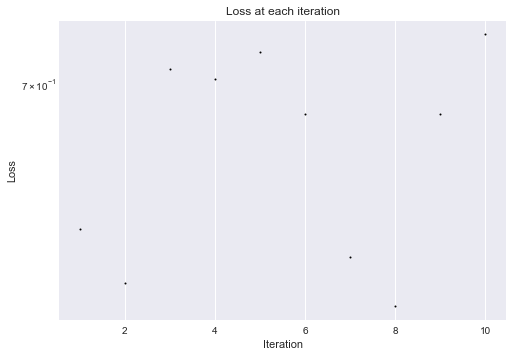

In [27]:
# ---- A while later ...

# Load the parameter values
param_df = pd.read_csv('parameter_values.csv')

# Add column for loss
param_df['loss'] = param_df['auc_score'].map(lambda x: 1-x)

# Plot the loss at each iteration
plt.semilogy(np.arange(1,max_evals+1), param_df['loss'], 'ko', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss at each iteration')
plt.show()

## SkOpt: Bayesian optimization

In [28]:
# ---- Set configuration space
parameters = collections.OrderedDict(
    [
        ('gradientboostingclassifier__n_estimators'    , (10, 15)),
        ('gradientboostingclassifier__max_depth'       , (1, 3)),
        ('gradientboostingclassifier__learning_rate'   , (0.1, 0.2)),
        ('gradientboostingclassifier__min_samples_leaf', (5, 10))
    ])

In [29]:
# ---- Instantiate objective function
objective = SkOptObjective(X_train, y_train)
objective.setEstimator(pipeline_search['GradientBoostingClassifier'])
objective.paramKeys(parameters.keys())

In [30]:
%%time
# ---- Bayesian optimization
clf_gp_ei = gp_minimize(func=objective, dimensions=parameters.values(), 
                        n_calls=30, random_state=0, acq_func="EI", n_jobs=-1)
print("Best score=%.4f (EI)" % clf_gp_ei.fun)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=-0.7165 (EI)
CPU times: user 19.8 s, sys: 3.85 s, total: 23.6 s
Wall time: 2min 26s


In [31]:
# ---- Best set of hyper-parameter based on expected improvement
print("""EI best parameters:
- n_estimators= %d
- max_depth= %d
- learning_rate= %.6f
- min_samples_leaf= %d""" % (clf_gp_ei.x[0], clf_gp_ei.x[1], 
                             clf_gp_ei.x[2], clf_gp_ei.x[3]))

EI best parameters:
- n_estimators= 10
- max_depth= 3
- learning_rate= 0.100220
- min_samples_leaf= 8


In [32]:
# ---- Bayesian optimization
clf_gp_lcb = gp_minimize(func=objective, dimensions=parameters.values(), n_calls=30, random_state=0, acq_func="LCB", n_jobs=-1)
print("Best score=%.4f (LCB)" % clf_gp_lcb.fun)

Best score=-0.7163 (LCB)


In [33]:
# ---- Best set of hyper-parameter based on lower confidence bound
print("""LCB best parameters:
- n_estimators= %d
- max_depth= %d
- learning_rate= %.6f
- min_samples_leaf= %d""" % (clf_gp_lcb.x[0], clf_gp_lcb.x[1],
                             clf_gp_lcb.x[2], clf_gp_lcb.x[3]))

LCB best parameters:
- n_estimators= 10
- max_depth= 3
- learning_rate= 0.100194
- min_samples_leaf= 10


In [34]:
# ---- Bayesian optimization
clf_gp_pi  = gp_minimize(func=objective, dimensions=parameters.values(), n_calls=30, random_state=0, acq_func="PI", n_jobs=-1)
print("Best score=%.4f (PI)" % clf_gp_pi.fun)

Best score=-0.7165 (PI)


In [35]:
# ---- Best set of hyper-parameter based on probability improvement
print("""PI best parameters:
- n_estimators= %d
- max_depth= %d
- learning_rate= %.6f
- min_samples_leaf= %d""" % (clf_gp_pi.x[0], clf_gp_pi.x[1],
                             clf_gp_pi.x[2], clf_gp_pi.x[3]))

PI best parameters:
- n_estimators= 10
- max_depth= 3
- learning_rate= 0.100470
- min_samples_leaf= 10


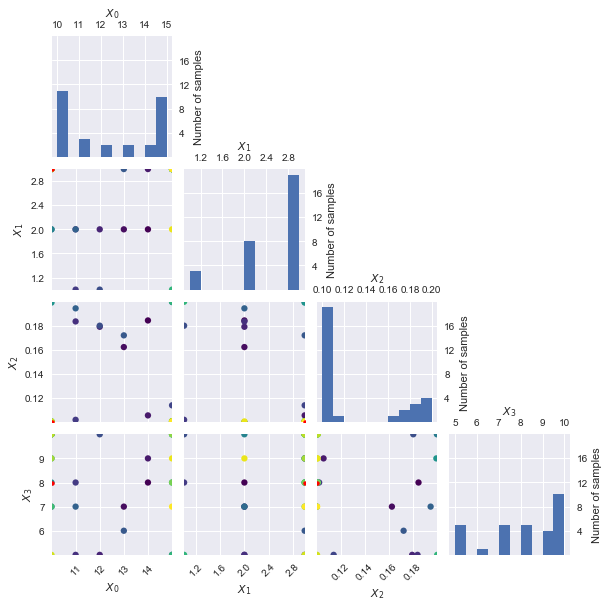

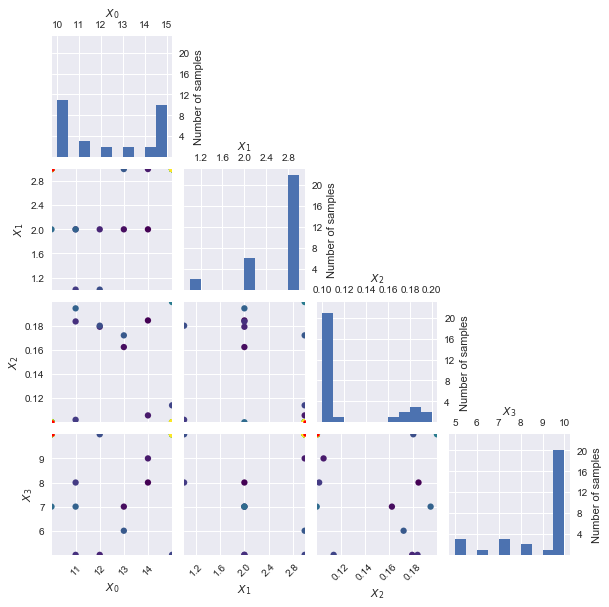

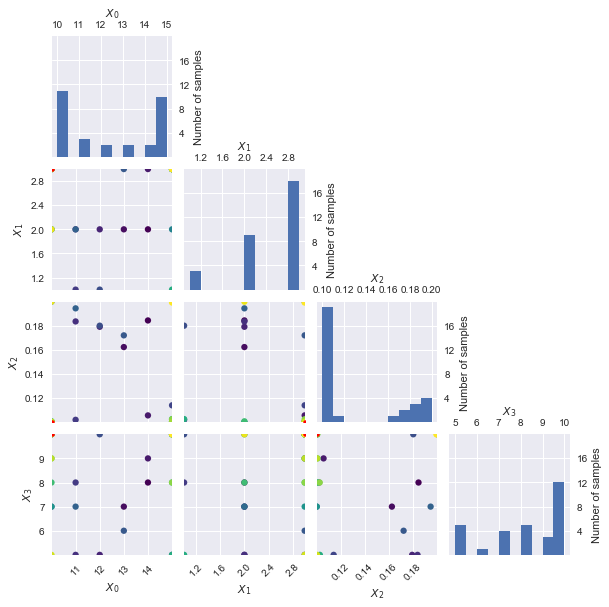

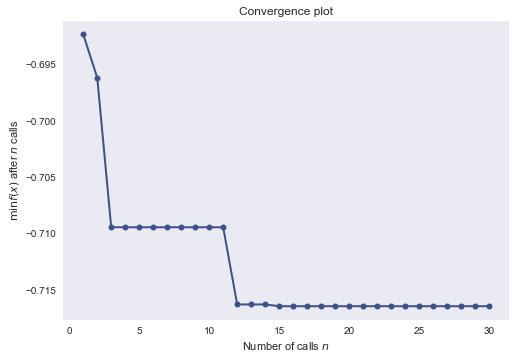

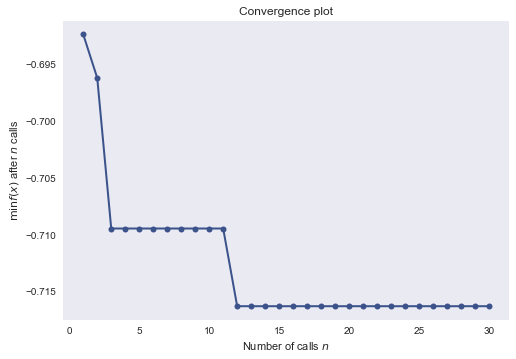

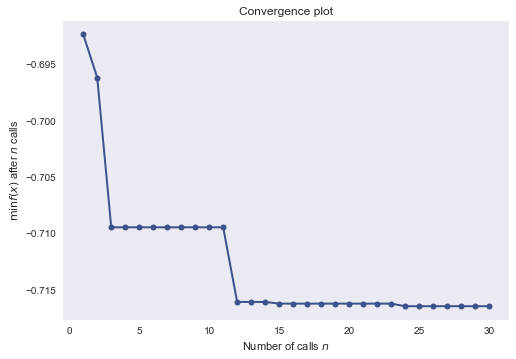

In [36]:
# ---- Evalution
plot_evaluations(clf_gp_ei, bins=10)
plt.show()

plot_evaluations(clf_gp_lcb, bins=10)
plt.show()

plot_evaluations(clf_gp_pi, bins=10)
plt.show()

# ---- Convergence
plot_convergence(clf_gp_ei);
plt.show()

plot_convergence(clf_gp_lcb);
plt.show()

plot_convergence(clf_gp_pi);
plt.show()

## Optunity (AREA STILL IN DEVELOPEMENT)

In [ ]:
# ---- Parameter tuning with Optunity 
import optunity
import optunity as opt
import optunity.metrics
import optunity.cross_validation
import optunity.metrics

In [ ]:
# ---- Basic parameters set 
space  = {'gradientboostingclassifier__n_estimators'    : [10, 15],
          'gradientboostingclassifier__max_depth'       : [1, 3],
          'gradientboostingclassifier__learning_rate'   : [0.1, 0.2],
          'gradientboostingclassifier__min_samples_leaf': [5, 10]
          } 

In [ ]:
# ---- Set basic variables
num_folds=5
num_iter=2
num_evals=2
random_state=42

# ---- Outer cross-validation to estimate performance of whole pipeline
@optunity.cross_validated(x=X_train.todense(), y=y_train.values, num_folds=num_folds,
                          strata=optunity.cross_validation.strata_by_labels(y_train),
                          aggregator=optunity.cross_validation.identity)
def nested_cv(x_train, y_train, x_test, y_test):
    # inner cross-validation to estimate performance of a set of hyperparameters
    @optunity.cross_validated(x=x_train, y=y_train, num_folds=num_folds-1, num_iter=num_iter,
                              strata=optunity.cross_validation.strata_by_labels(y_train))
    def inner_cv(x_train, y_train, x_test, y_test, 
                 gradientboostingclassifier__n_estimators, gradientboostingclassifier__max_depth, 
                 gradientboostingclassifier__learning_rate, gradientboostingclassifier__min_samples_leaf):
        # note that the x_train, ... variables in this function are not the same
        # as within nested_cv!
        params={}
        params['gradientboostingclassifier__n_estimators']     = int(gradientboostingclassifier__n_estimators)
        params['gradientboostingclassifier__max_depth']        = int(gradientboostingclassifier__max_depth)
        params['gradientboostingclassifier__learning_rate']    = float(gradientboostingclassifier__learning_rate)
        params['gradientboostingclassifier__min_samples_leaf'] = int(gradientboostingclassifier__min_samples_leaf)

        model = pipeline_search['GradientBoostingClassifier'].set_params(**params)
        
        model.fit(x_train, y_train)
        
        predictions = model.predict_proba(x_test)[:, 1]

        return optunity.metrics.roc_auc(y_test, predictions)


    hpars, info, _ = optunity.maximize(inner_cv, num_evals=num_evals, **space)

    print('Hyperparameters: ' + str(hpars))
    print('Cross-validated AUROC after tuning: %1.3f' % info.optimum)

    model = pipe_classifiers['GradientBoostingClassifier'].set_params(gradientboostingclassifier__n_estimators=int(hpars['gradientboostingclassifier__n_estimators']),
                                                  gradientboostingclassifier__max_depth=int(hpars['gradientboostingclassifier__max_depth']),
                                                  gradientboostingclassifier__learning_rate=float(hpars['gradientboostingclassifier__learning_rate']),
                                                  gradientboostingclassifier__min_samples_leaf=int(hpars['gradientboostingclassifier__min_samples_leaf']))
    
    model.fit(x_train, y_train)
    predictions = model.predict_proba(x_test)[:, 1]

    # return AUROC, optimized hyperparameters and AUROC during hyperparameter search
    return optunity.metrics.roc_auc(y_test, predictions), hpars, info.optimum

In [ ]:
# ---- Run hyper-parameter tunning
nested_cv_result = nested_cv()
aucs, hpars, optima = zip(*nested_cv_result)

In [ ]:
print("Nested AUCs: " + str(aucs))
print('')
print("hpars: " + "\n".join(map(str, hpars)))
print('')
print("optima: " + str(optima))

mean_auc = sum(aucs) / len(aucs)
print('')
print("Mean AUC %1.3f" % mean_auc)